In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from mabe.models import EpsilonGreedy, LinTS, LinUCB, ThompsonSampling, UCB
from mabe.simulator import *

sns.set_style('darkgrid')

In [2]:
# Configuration of the simulator
n_users = 200
n_products = 10
n_interactions = 25000

In [3]:
# Product categories
product_categories = ['technology', 'fashion', 'books', 'sports', 'home']

# Generate users and products
users = [generate_user(i, product_categories) for i in range(n_users)]
products_df = generate_products(n_products, product_categories)

In [4]:
n_arms = n_products

In [5]:
n_runs = 5

In [6]:
rewards_runs = []
regrets_runs = []
accuracies = []
for i in range(n_runs):
    policies = {
        "random": EpsilonGreedy(n_arms=n_arms, epsilon=1.),
        "epsilon_greedy": EpsilonGreedy(n_arms=n_arms, epsilon=0.1),
        "ucb": UCB(n_arms=n_arms, alpha=0.25),
        "thompson_sampling": ThompsonSampling(n_arms=n_arms),
        "linucb": LinUCB(n_arms=n_arms, context_dim=10, alpha=0.75),
        "lints": LinTS(n_arms=n_arms, context_dim=10, v=0.3),
    }
    cum_reward = [0] * len(policies)
    cum_regret = [0] * len(policies)
    accuracy = [0] * len(policies)
    rewards = [[0] for _ in range(len(policies))]
    regrets = [[0] for _ in range(len(policies))]
    for i in range(n_interactions):
        user = np.random.choice(users)
        start = pd.Timestamp('2025-01-01 00:00:00')
        end = pd.Timestamp('2025-12-31 23:59:59')
        timestamp = start + pd.to_timedelta(np.random.uniform(0, 1) * (end - start))

        # Create context vectors
        context_df = products_df.assign(**user)
        context_df = context_df.loc[:, ['age', 'gender', 'preferred_category', 'category']]
        # List of categorical columns
        categorical_cols = ['gender', 'preferred_category', 'category']
        categories = [['M', 'F'], product_categories, product_categories]
        # Create the column transformer
        column_transformer = ColumnTransformer(
            transformers=[
                ('onehot', OneHotEncoder(sparse_output=False, categories=categories, drop='first'), categorical_cols)
            ],
            remainder='passthrough'  # or 'passthrough' to keep non-categorical columns
        )
        # Fit and transform the data
        encoded_array = column_transformer.fit_transform(context_df)
        x_contexts = list(encoded_array[:, :, None])

        cat_splits = (['technology', 'sports'], ['fashion', 'books', 'home'])
        interactions = simulate_interactions(user, products_df, timestamp, cat_splits)

        for j, key in enumerate(policies.keys()):
            recommendation = policies[key].select_action(x_contexts)
            product = interactions.iloc[recommendation, 0]
            click = interactions.iloc[recommendation, -1]

            if recommendation == int(interactions.loc[interactions['ctr'].idxmax()]['product_id']):
                accuracy[j] += 1
            cum_reward[j] += click
            cum_regret[j] += interactions.iloc[:, -1].max() - click
            rewards[j].append(cum_reward[j])
            regrets[j].append(cum_regret[j])

            policies[key].update(recommendation, x_contexts[recommendation], click)
    accuracies.append(accuracy)
    rewards_runs.append(rewards)
    regrets_runs.append(regrets)

In [7]:
rewards = np.array(rewards_runs).mean(axis=0)
regrets = np.array(regrets_runs).mean(axis=0)

In [8]:
print('Proportion of acceses to the web page that ended in a click:')
print('Random Choice:', rewards[0, -1] / n_interactions)
print('Epsilon-Greedy:', rewards[1, -1] / n_interactions)
print('Upper Confidence Bound:', rewards[2, -1] / n_interactions)
print('Thompson Sampling:', rewards[3, -1] / n_interactions)
print('Linear Upper Confidence Bound:', rewards[4, -1] / n_interactions)
print('Linear Thompson Sampling:', rewards[5, -1] / n_interactions)

Proportion of acceses to the web page that ended in a click:
Random Choice: 0.28853599999999996
Epsilon-Greedy: 0.394472
Upper Confidence Bound: 0.39683199999999996
Thompson Sampling: 0.401768
Linear Upper Confidence Bound: 0.460096
Linear Thompson Sampling: 0.453664


In [9]:
accuracies = np.array(accuracies).mean(axis=0) / n_interactions

In [10]:
accuracies

array([0.101896, 0.226064, 0.240184, 0.234496, 0.728592, 0.662296])

In [11]:
print('Accuracy (nº of suggestions of the best possible action / nº of time steps):')
print('Random Choice:', accuracies[0])
print('Epsilon-Greedy:', accuracies[1])
print('Upper Confidence Bound:', accuracies[2])
print('Thompson Sampling:', accuracies[3])
print('Linear Upper Confidence Bound:', accuracies[4])
print('Linear Thompson Sampling:', accuracies[5])

Accuracy (nº of suggestions of the best possible action / nº of time steps):
Random Choice: 0.101896
Epsilon-Greedy: 0.22606400000000001
Upper Confidence Bound: 0.240184
Thompson Sampling: 0.23449599999999998
Linear Upper Confidence Bound: 0.728592
Linear Thompson Sampling: 0.6622960000000001


Text(0, 0.5, 'Cumulative reward')

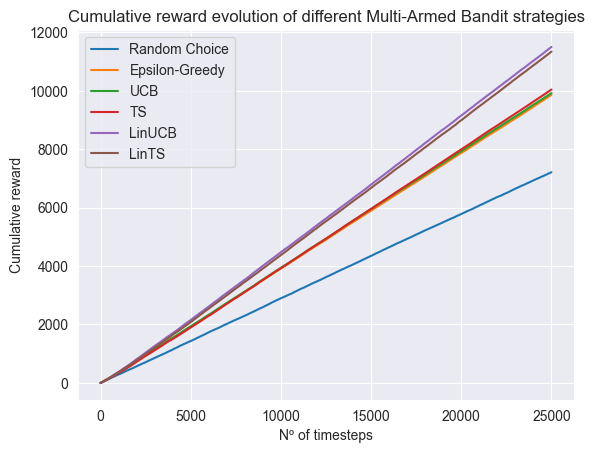

In [12]:
plt.plot(np.arange(n_interactions+1), rewards[0, :], label='Random Choice')
plt.plot(np.arange(n_interactions+1), rewards[1, :], label='Epsilon-Greedy')
plt.plot(np.arange(n_interactions+1), rewards[2, :], label='UCB')
plt.plot(np.arange(n_interactions+1), rewards[3, :], label='TS')
plt.plot(np.arange(n_interactions+1), rewards[4, :], label='LinUCB')
plt.plot(np.arange(n_interactions+1), rewards[5, :], label='LinTS')
plt.legend()
plt.title('Cumulative reward evolution of different Multi-Armed Bandit strategies')
plt.xlabel('Nº of timesteps')
plt.ylabel('Cumulative reward')

Text(0, 0.5, 'Recompensa acumulada')

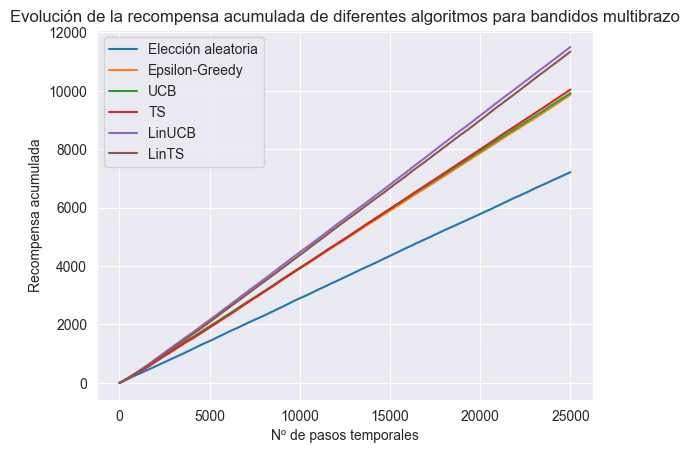

In [13]:
plt.plot(np.arange(n_interactions+1), rewards[0, :], label='Elección aleatoria')
plt.plot(np.arange(n_interactions+1), rewards[1, :], label='Epsilon-Greedy')
plt.plot(np.arange(n_interactions+1), rewards[2, :], label='UCB')
plt.plot(np.arange(n_interactions+1), rewards[3, :], label='TS')
plt.plot(np.arange(n_interactions+1), rewards[4, :], label='LinUCB')
plt.plot(np.arange(n_interactions+1), rewards[5, :], label='LinTS')
plt.legend()
plt.title('Evolución de la recompensa acumulada de diferentes algoritmos para bandidos multibrazo')
plt.xlabel('Nº de pasos temporales')
plt.ylabel('Recompensa acumulada')

Text(0, 0.5, 'Regret acumulado')

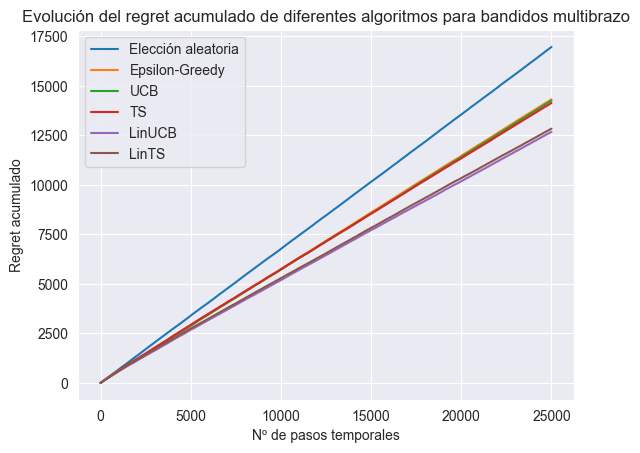

In [14]:
plt.plot(np.arange(n_interactions+1), regrets[0, :], label='Elección aleatoria')
plt.plot(np.arange(n_interactions+1), regrets[1, :], label='Epsilon-Greedy')
plt.plot(np.arange(n_interactions+1), regrets[2, :], label='UCB')
plt.plot(np.arange(n_interactions+1), regrets[3, :], label='TS')
plt.plot(np.arange(n_interactions+1), regrets[4, :], label='LinUCB')
plt.plot(np.arange(n_interactions+1), regrets[5, :], label='LinTS')
plt.legend()
plt.title('Evolución del regret acumulado de diferentes algoritmos para bandidos multibrazo')
plt.xlabel('Nº de pasos temporales')
plt.ylabel('Regret acumulado')

Text(0, 0.5, 'Cumulative regret')

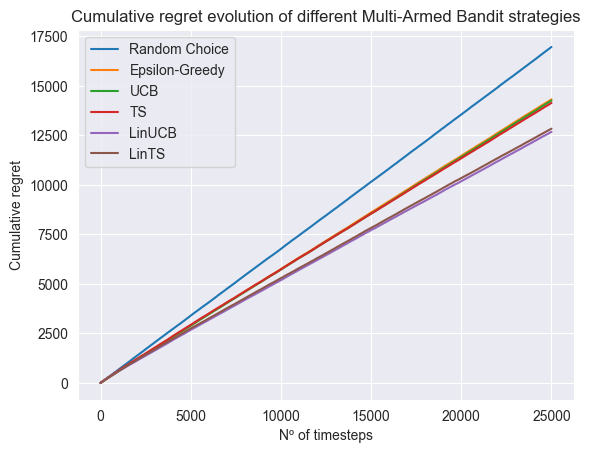

In [15]:
plt.plot(np.arange(n_interactions+1), regrets[0, :], label='Random Choice')
plt.plot(np.arange(n_interactions+1), regrets[1, :], label='Epsilon-Greedy')
plt.plot(np.arange(n_interactions+1), regrets[2, :], label='UCB')
plt.plot(np.arange(n_interactions+1), regrets[3, :], label='TS')
plt.plot(np.arange(n_interactions+1), regrets[4, :], label='LinUCB')
plt.plot(np.arange(n_interactions+1), regrets[5, :], label='LinTS')
plt.legend()
plt.title('Cumulative regret evolution of different Multi-Armed Bandit strategies')
plt.xlabel('Nº of timesteps')
plt.ylabel('Cumulative regret')